## Программирование и компьютерные науки

### Семинар 5

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

### Мультиклассовая классификация

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
data = load_wine()
print(data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [35]:
X = data['data']
y = data['target']

In [36]:
X.shape

(178, 13)

<Axes: >

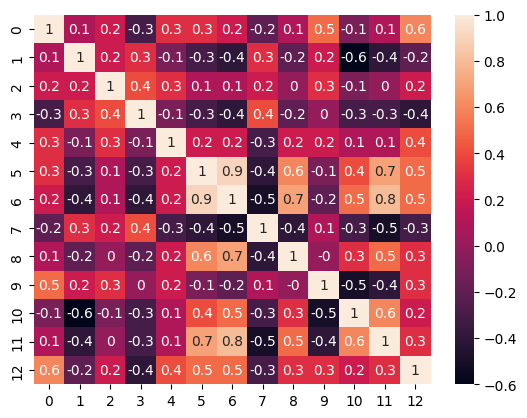

In [37]:
sns.heatmap(np.round(pd.DataFrame(X).corr(), 1), annot=True)

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=True, stratify=y, 
                                                    random_state=42)

#### One-vs-All

$$a(x) = argmax_ {k \in \{1, ..., K\}} b_k(x)$$

In [40]:
from sklearn.multiclass import OneVsRestClassifier

In [41]:
estimator = LogisticRegression(solver='newton-cg')
ovr_model = OneVsRestClassifier(estimator)
ovr_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(solver='newton-cg'))

In [42]:
cross_val_score(ovr_model, X_train, y_train, cv=3, scoring='accuracy')

array([0.95238095, 0.95121951, 0.95121951])

In [43]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([59, 71, 48]))

#### All vs All

$C_k^2$

$$ a(x) = argmax \sum_{i=1}^K \sum_{j \ne i} [a_{ij}(x) = k ]$$

In [44]:
from sklearn.multiclass import OneVsOneClassifier

In [45]:
estimator = SVC()
ovo_model = OneVsOneClassifier(estimator)

In [46]:
ovo_model.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC())

In [48]:
cross_val_score(ovo_model, X_train, y_train, cv=3, scoring='accuracy').mean()

0.6691831204026326

#### Logistic Regression

In [49]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [51]:
cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')

array([0.92857143, 0.92682927, 0.97560976])

In [52]:
model.coef_.shape, model.intercept_

((3, 13), array([-0.25667476,  0.34970417, -0.06587706]))

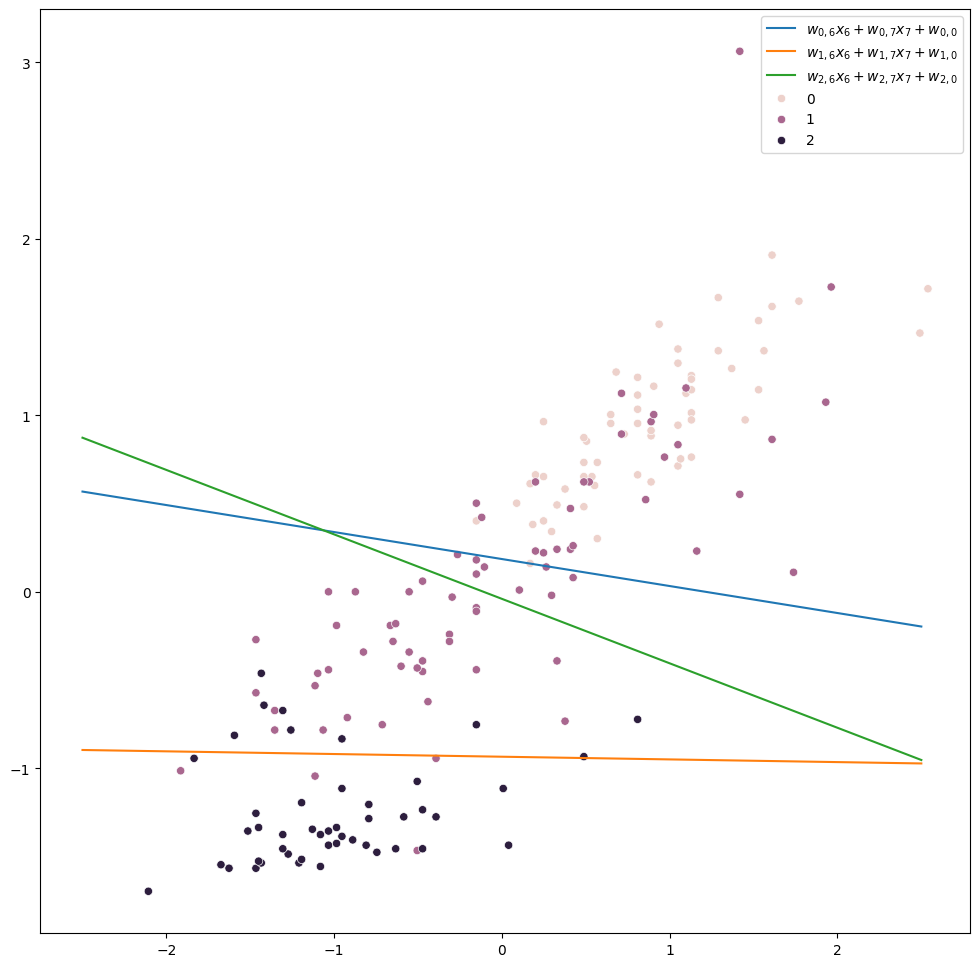

In [53]:
w_01 = model.coef_[0][5]
w_02 = model.coef_[0][6]
w_00 = model.intercept_[0]

w_11 = model.coef_[1][5]
w_12 = model.coef_[1][6]
w_10 = model.intercept_[1]

w_21 = model.coef_[2][5]
w_22 = model.coef_[2][6]
w_20 = model.intercept_[2]

x_arr = np.linspace(-2.5, 2.5, 3000)
plt.figure(figsize=(12, 12))
plt.plot(x_arr, -(w_00 + w_01 * x_arr) / w_02, label='$w_{0,6}x_6 + w_{0,7}x_7 + w_{0, 0}$')
plt.plot(x_arr, -(w_10 + w_11 * x_arr) / w_12, label='$w_{1,6}x_6 + w_{1,7}x_7 + w_{1, 0}$')
plt.plot(x_arr, -(w_20 + w_21 * x_arr) / w_22, label='$w_{2,6}x_6 + w_{2,7}x_7 + w_{2, 0}$')
sns.scatterplot(x=X_scaled[:, 5], y=X_scaled[:, 6], hue=y)
plt.show()

## Оценка качества работы классификатора
### Бинарные метрики
Обучение и оценка качества модели производится на независимых множествах примеров. Как правило, имеющующиеся примеры разбивают на два подмножества: обучение (`train`) и контроль (`test`). Выбор пропорции разбиения — компромисс: большой размер обучения ведет к более богатым информацией и качественным алгоритмам, большой размер контрольной выборки ведет к менее шумной оценке качества.

Для оценки качества классификации рассматривают [матрицу ошибок](http://en.wikipedia.org/wiki/Confusion_matrix): строчки соответствуют прогнозу модели, столбцы — истинным ответам, ячейки содержат число примеров тестовой выборки. Если для некоторого алгоритма $a(\cdot)$ и объекта $x$ выполняется $a(x) = 1$, то говорят, что алгоритм $a$ _выделяет_ объект $x$.

| | y = +1 | y = -1 |
|---|------|------|
|   **a(x) = +1**  | TP| FP |
| **a(x) = -1**| FN | TN |

Диагональ матрицы ошибок содержит правильно классифицированные положительные (TP) и отрицательные (TN) примеры. False Positive (FP) — ошибки I рода (ложное срабатывание, положили в спам хорошее письмо), False Negative (FN) — ошибки II рода (не отфильтровали спам). Ошибки I и II рода могут иметь различную стоимость.

Часто рассматриваются следующие метрики качества бинарной классификации:
  - Доля правильных ответов (Accuracy):
  $$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$
  - Точность/precision (доля действительно положительных объектов среди объектов, выделенных алгоритмом):
  $$precision = \frac{TP}{TP + FP}$$
  - Полнота/recall (доля выделенных алгоритмом объектов среди всех положительных объектов выборки):
  $$recall = \frac{TP}{TP + FN}$$
  - $F_1$-мера (среднее гармоническое между точностью и полнотой)
  $$F_1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$
  
Подробнее про метрики качества бинарной классификации на Википедии: [Precision and Recall](http://en.wikipedia.org/wiki/Precision_and_recall).

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [22]:
preds = model.predict(X_test)

In [23]:
print(f'F1 score: {f1_score(y_test, preds, average="macro"):.2f}')
print(f'Precision: {precision_score(y_test, preds, average="macro"):.2f}')
print(f'Recall: {recall_score(y_test, preds, average="macro"):.2f}')

F1 score: 0.98
Precision: 0.98
Recall: 0.98


### Выбор порога классификации
Многие модели классификации получают оценку принадлежности положительному классу $b(x) \in \mathbb{R}$, после чего принимается решение о классификации объекта путем сравнения оценки с некоторым порогом:

$a(x) = \begin{cases}
        +1, \, b(x) \ge t,\\
        -1, \, b(x) < t.
        \end{cases}$
        
Матрица ошибок и все производные от нее метрики (Accuracy, Precision, Recall, etc.) зависят от порога $t$:
![Порог классификации](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/seminars/images/binary_threshold.png?raw=1) 

Поскольку иногда необходимо оценить качество модели $b(x),$ предсказывающей не конкретную метку класса, а степень принадлежности классу (т.е. вне зависимости от значения порога), рассматривают координатную плоскость, по осям которой отложены значения метрик, а качество работы классификатора представлено в виде кривой — траектории изменения соответствующих метрик при варьировании порога:

![Принцип построения ROC-кривой](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/seminars/images/roc_trajectory.png?raw=1)

Наиболее распространены ROC-кривые и Precision/Recall кривые.
 - По осям Ox и Oy ROC-кривой отложены соответственно False Positive Rate (FPR) и True Positive Rate (TPR):
 $$FPR = \frac{FP}{FP + TN},$$
 $$TPR = \frac{TP}{FN + TP}.$$
 - По осям Ox и Oy PR-кривой отложены соответственно Recall и Precision.


Аббревиатура ROC ([Receiver Operating Characteristic](en.wikipedia.org/wiki/Receiver_operating_characteristic)) была унаследована из инженерного дела.

![Примеры ROC-кривых](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/seminars/images/roc_and_pr_curves.png?raw=1)

В случае, если необходимо сравнить качество классификаторов вне зависимости от порога, применяют интегральные числовые метрики, например AUC-ROC (**A**rea **U**nder RO**C**) — площадь под ROC-кривой классификатора. AUC-ROC идеально работающего классификатора равно 1. Идеальный случайный классификатор в среднем имеет AUC-ROC=0.5.

Построим описанные кривые для логистической регрессии, обученной на описанном выше датасете.

* PR-кривая проходит через точку (0,0).

* Если при каком-то значении порога $t$ алгоритм $a(x)$ идеально разделяет объекты 2 классов, то PR-кривая проходит через точку (1,1).


In [27]:
from sklearn.metrics import precision_recall_curve

In [ ]:
model = LogisticRegression()

In [25]:
.fit(X_train, y_train)

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

ValueError: multiclass format is not supported

In [29]:
from sklearn.metrics import auc

print(f'AUC PR: {auc(recall, precision):.2f}')

NameError: name 'recall' is not defined

* ROC проходит через точки (0,0) и (1,1)
* Если при каком-то значении порога $t$ алгоритм $a(x)$ идеально разделяет объекты 2 классов, то ROC проходит через точку (0,1).

In [30]:
from sklearn.metrics import roc_curve

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

NameError: name 'lr_model' is not defined

In [ ]:
print(f'AUC ROC: {auc(fpr, tpr):.2f}')